In [1]:
from mmseg.apis import init_model, inference_model
from mmengine.config import Config
import torch
from cv2 import distanceTransform, DIST_L2, DIST_MASK_PRECISE
import numpy as np

from mmseg.structures.seg_data_sample import SegDataSample
from mmseg.utils.typing_utils import SampleList

In [2]:
nclasses = 18

In [3]:
cfg = Config.fromfile('./models/mask2former/mask2former_swin-t_1xb2-90k_soccernet.py')

In [4]:
model = init_model(cfg, 'best_mIoU_iter_46200.pth')

SegDataPreProcessor: 


Loads checkpoint by local backend from path: best_mIoU_iter_46200.pth


In [5]:
result = inference_model(model, './Dataset/Images/Stadium_1_Match_1_in_1fps_0491.png')
# result = inference_model(model, './Dataset/Images/Stadium_1_Match_1_in001.png')

/home/vgaspar/miniconda3/envs/mmsegTest/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400430266/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
# 'result' is either a SegDataSample or a SampleList. In our case it is a SegDataSample. Tell Pylance that.
result: SegDataSample

In [7]:
result

<SegDataSample(

    META INFORMATION
    scale_factor: (1.0, 1.0)
    img_padding_size: (0, 0, 0, 8)
    ori_shape: (1080, 1920)
    pad_shape: torch.Size([1088, 1920])
    img_shape: (1080, 1920)
    img_path: './Dataset/Images/Stadium_1_Match_1_in_1fps_0491.png'

    DATA FIELDS
    seg_logits: <PixelData(
        
            META INFORMATION
        
            DATA FIELDS
            data: tensor([[[9.7864e-01, 9.7864e-01, 9.8182e-01,  ..., 9.8459e-01,
                          9.8324e-01, 9.8324e-01],
                         [9.7864e-01, 9.7864e-01, 9.8182e-01,  ..., 9.8459e-01,
                          9.8324e-01, 9.8324e-01],
                         [9.8082e-01, 9.8082e-01, 9.9950e-01,  ..., 9.9957e-01,
                          9.8407e-01, 9.8407e-01],
                         ...,
                         [9.9207e-01, 9.9207e-01, 1.0000e+00,  ..., 1.0000e+00,
                          9.8456e-01, 9.8456e-01],
                         [9.9200e-01, 9.9200e-01, 1.0000e+00, 

In [8]:
result.pred_sem_seg.data.squeeze().cpu().numpy() # type: ignore

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [9]:
pred = result.pred_sem_seg.data.squeeze().cpu().numpy() # type: ignore
type(pred)

numpy.ndarray

In [10]:
palette = [[0, 0, 0], [255, 255, 255], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255], [128, 0, 0], [0, 128, 0], [0, 0, 128], [64, 64, 64], [128, 128, 0], [128, 0, 128], [0, 128, 128], [255, 128, 0], [192, 192, 192], [128, 128, 128]]

In [11]:
from PIL import Image

In [12]:
# Save the prediction as an image
img = Image.fromarray(pred.astype('uint8'), mode='P')

In [13]:
img.putpalette(np.array(palette, dtype=np.uint8))

In [14]:
# Save img
img.save('test.png')

In [15]:
from matplotlib import pyplot as plt


gt = Image.open('./Dataset/Labels/Stadium_1_Match_1_in_1fps_0491.png')

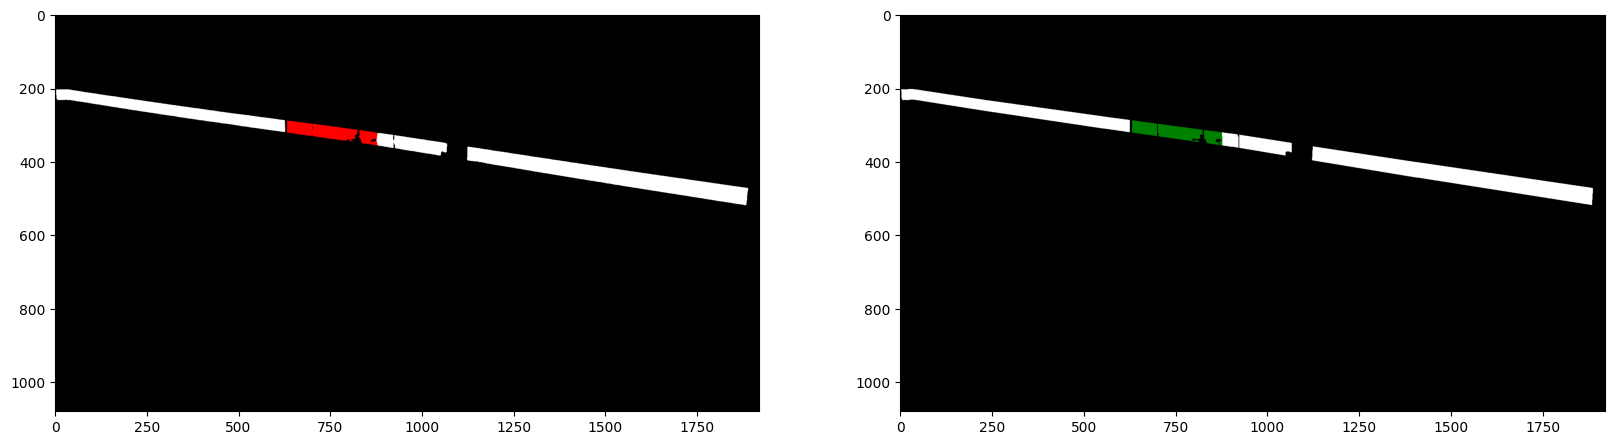

In [16]:
# Show pred and gt
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(gt)
plt.show()

In [17]:
# gt = np.array(gt)
gt = torch.tensor(np.array(gt), dtype=torch.int64, device='cuda')
gt

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')

In [18]:
pred = result.pred_sem_seg.data.squeeze() # type: ignore
pred

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')

In [19]:
gt_one_hot = torch.nn.functional.one_hot(gt, num_classes=nclasses).permute(2, 0, 1).float()

In [20]:
pred_one_hot = torch.nn.functional.one_hot(pred, num_classes=nclasses).permute(2, 0, 1).float()
pred_one_hot

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [21]:
# pred_one_hot = torch.tensor([[[0, 0, 0],
#                               [0, 1, 0],
#                               [0, 0, 0]]] * nclasses, dtype=torch.float32, device=pred.device)

In [22]:
kernel = torch.tensor([[-1, -1, -1],
                       [-1,  8, -1],
                       [-1, -1, -1]], dtype=torch.float32, device=pred.device)
kernel

tensor([[-1., -1., -1.],
        [-1.,  8., -1.],
        [-1., -1., -1.]], device='cuda:0')

In [23]:
pred_one_hot.unsqueeze(1).shape

torch.Size([18, 1, 1080, 1920])

In [24]:
pred_borders = torch.nn.functional.conv2d(pred_one_hot.unsqueeze(1), kernel.unsqueeze(0).unsqueeze(0), padding='same')
pred_borders.shape

torch.Size([18, 1, 1080, 1920])

In [25]:
pred_borders = pred_borders.squeeze()
pred_borders.shape

torch.Size([18, 1080, 1920])

In [26]:
gt_borders = torch.nn.functional.conv2d(gt_one_hot.unsqueeze(1), kernel.unsqueeze(0).unsqueeze(0), padding='same')
gt_borders.squeeze_()
gt_borders.shape

torch.Size([18, 1080, 1920])

In [27]:
pred_borders

tensor([[[5., 3., 3.,  ..., 3., 3., 5.],
         [3., 0., 0.,  ..., 0., 0., 3.],
         [3., 0., 0.,  ..., 0., 0., 3.],
         ...,
         [3., 0., 0.,  ..., 0., 0., 3.],
         [3., 0., 0.,  ..., 0., 0., 3.],
         [5., 3., 3.,  ..., 3., 3., 5.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [28]:
pred_borders = pred_borders.clamp(0, 1)
pred_borders

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [29]:
gt_borders.clamp_(0, 1)

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [30]:
Image.fromarray(pred_borders[2].cpu().numpy().astype('uint8') * 255, mode='L').save('borders.png')

Compute the mask of pixels at distance d from the contours

In [75]:
d = 3

In [76]:
# Create an odd length squared numpy array of ones unless for the pixel in the center that is 0
kernel = np.ones((d*2+1, d*2+1), dtype=np.uint8)
kernel[d, d] = 0
kernel

array([[1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1]], dtype=uint8)

In [77]:
kernel = distanceTransform(kernel, DIST_L2, DIST_MASK_PRECISE)
kernel

array([[4.2426405, 3.6055512, 3.1622777, 3.       , 3.1622777, 3.6055512,
        4.2426405],
       [3.6055512, 2.828427 , 2.236068 , 2.       , 2.236068 , 2.828427 ,
        3.6055512],
       [3.1622777, 2.236068 , 1.4142135, 1.       , 1.4142135, 2.236068 ,
        3.1622777],
       [3.       , 2.       , 1.       , 0.       , 1.       , 2.       ,
        3.       ],
       [3.1622777, 2.236068 , 1.4142135, 1.       , 1.4142135, 2.236068 ,
        3.1622777],
       [3.6055512, 2.828427 , 2.236068 , 2.       , 2.236068 , 2.828427 ,
        3.6055512],
       [4.2426405, 3.6055512, 3.1622777, 3.       , 3.1622777, 3.6055512,
        4.2426405]], dtype=float32)

In [78]:
kernel = torch.tensor(kernel, dtype=torch.float32, device='cuda')
kernel

tensor([[4.2426, 3.6056, 3.1623, 3.0000, 3.1623, 3.6056, 4.2426],
        [3.6056, 2.8284, 2.2361, 2.0000, 2.2361, 2.8284, 3.6056],
        [3.1623, 2.2361, 1.4142, 1.0000, 1.4142, 2.2361, 3.1623],
        [3.0000, 2.0000, 1.0000, 0.0000, 1.0000, 2.0000, 3.0000],
        [3.1623, 2.2361, 1.4142, 1.0000, 1.4142, 2.2361, 3.1623],
        [3.6056, 2.8284, 2.2361, 2.0000, 2.2361, 2.8284, 3.6056],
        [4.2426, 3.6056, 3.1623, 3.0000, 3.1623, 3.6056, 4.2426]],
       device='cuda:0')

In [79]:
kernel = kernel <= d
kernel

tensor([[False, False, False,  True, False, False, False],
        [False,  True,  True,  True,  True,  True, False],
        [False,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True,  True, False],
        [False,  True,  True,  True,  True,  True, False],
        [False, False, False,  True, False, False, False]], device='cuda:0')

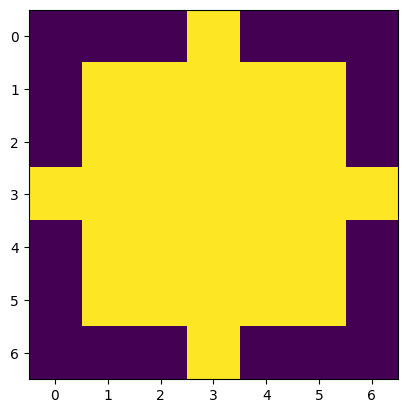

In [80]:
plt.figure()
plt.imshow(kernel.cpu().int().numpy())
plt.show()

In [81]:
kernel = kernel.float()
kernel

tensor([[0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 1., 1., 1., 1., 0.],
        [0., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 0.],
        [0., 1., 1., 1., 1., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0.]], device='cuda:0')

In [82]:
pred_d_border = torch.nn.functional.conv2d(pred_borders.unsqueeze(1), kernel.unsqueeze(0).unsqueeze(0), padding='same')
pred_d_border

tensor([[[[7., 7., 8.,  ..., 8., 7., 7.],
          [7., 7., 8.,  ..., 8., 7., 7.],
          [8., 8., 9.,  ..., 9., 8., 8.],
          ...,
          [8., 8., 9.,  ..., 9., 8., 8.],
          [7., 7., 8.,  ..., 8., 7., 7.],
          [7., 7., 8.,  ..., 8., 7., 7.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [83]:
pred_d_border = pred_d_border.squeeze()
pred_d_border.shape

torch.Size([18, 1080, 1920])

In [84]:
pred_d_border = pred_d_border.clamp(0, 1)
pred_d_border

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [85]:
gt_d_border = torch.nn.functional.conv2d(gt_borders.unsqueeze(1), kernel.unsqueeze(0).unsqueeze(0), padding='same').squeeze().clamp(0, 1)

In [86]:
Image.fromarray(pred_d_border[1].cpu().numpy().astype('uint8') * 255, mode='L').save('d1borders.png')

In [87]:
pred_one_hot.shape

torch.Size([18, 1080, 1920])

In [88]:
pred_d_border.shape

torch.Size([18, 1080, 1920])

In [89]:
pred_intersections = torch.logical_and(pred_one_hot, pred_d_border)

In [90]:
pred_intersections

tensor([[[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

In [91]:
Image.fromarray(pred_intersections[2].cpu().numpy().astype('uint8') * 255, mode='L').save('d1borders2.png')

In [92]:
gt_intersections = torch.logical_and(gt_one_hot, gt_d_border)

In [93]:
# Sum pred_intersections and gt_intersections
pred_intersections[2].sum(), gt_intersections[2].sum()

(tensor(2633, device='cuda:0'), tensor(2776, device='cuda:0'))

In [94]:
torch.sum(pred_intersections.logical_and(gt_intersections))

tensor(51592, device='cuda:0')

In [95]:
torch.sum(pred_intersections.logical_or(gt_intersections))

tensor(62250, device='cuda:0')

In [96]:
c = 2
torch.sum(pred_intersections[c].logical_and(gt_intersections[c])) / torch.sum(pred_intersections[c].logical_or(gt_intersections[c]))

tensor(0.7911, device='cuda:0')